# 2. Data preparation

---

### Setup

In [1]:
import sys
sys.path.insert(1, '../../utils')

import pandas as pd

original: pd.DataFrame = pd.read_csv('../qsar_oral_toxicity_after_profiling.csv', sep=';')

## 2.0. Data preparation

---

### Missing Values Imputation

---

In our dataset there are no missing values and therefore this step is not appliable.

### Outliers Imputation
---

In [2]:
#TODO

### Scaling

---

Since all variables are binary (0 or 1) they are already scaled. Therefore, no scaling is needed.

### Splits

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import ds_functions as ds

original_copy = original.copy(deep = True)

target = 'exp'
positive = True
negative = False
values = {'Original': [len(original_copy[original_copy[target] == positive]), len(original_copy[original_copy[target] == negative])]}

y: np.ndarray = original_copy.pop(target).values
X: np.ndarray = original_copy.values
labels: np.ndarray = pd.unique(y)

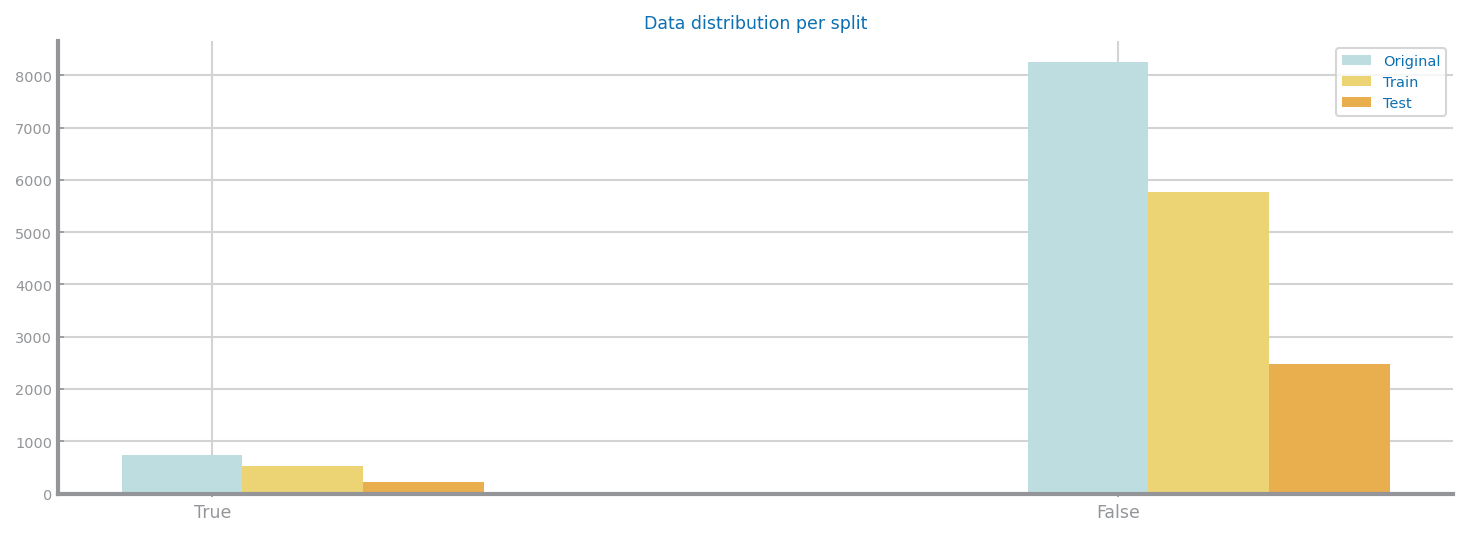

In [3]:
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per split', showXTickLabels = True)
plt.show()

### Data balancing

---

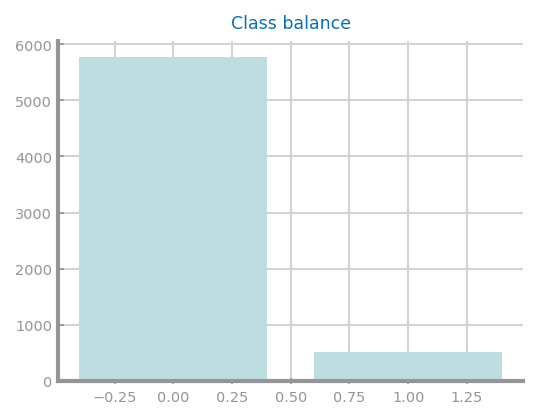

Minority class: 519
Majority class: 5774
Proportion: 0.09 : 1


In [22]:
import matplotlib.pyplot as plt

split = {}

columnsX = list(original.columns)
columnsX.remove(target)

split['X_train'] = pd.DataFrame(data=trnX, columns=columnsX)
split['y_train'] = pd.DataFrame(data=trnY, columns=[target])
split['X_test'] = pd.DataFrame(data=tstX, columns=columnsX)
split['y_test'] = pd.DataFrame(data=tstY, columns=[target])

trainData = pd.concat([split['X_train'], split['y_train']], axis = 1)
testData = pd.concat([split['X_test'], split['y_test']], axis = 1)

target_count = trainData['exp'].value_counts()
plt.figure()
plt.title('Class balance')
plt.bar(target_count.index, target_count.values)
plt.show()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('Minority class:', target_count[ind_min_class])
print('Majority class:', target_count[1-ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 3), ': 1')

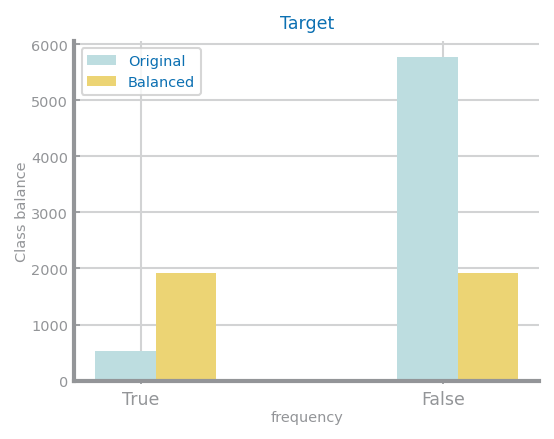

In [23]:
import ds_functions as ds

df_class_min = trainData[trainData['exp'] == min_class]
df_class_max = trainData[trainData['exp'] != min_class]

values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

FINAL_SIZE = len(df_class_max) // 3

# Oversampling
df_class_min_sample = df_class_min.sample(FINAL_SIZE, replace=True)
# Undersampling
df_class_max_sample = df_class_max.sample(FINAL_SIZE)

values['Balanced'] = [len(df_class_min_sample), len(df_class_max_sample)]

fig = plt.figure()
ds.multiple_bar_chart([target_count.index[ind_min_class], target_count.index[1-ind_min_class]], values,
                      title='Target', xlabel='frequency', ylabel='Class balance', showXTickLabels=True)
plt.show()

balanced = pd.concat((df_class_min_sample, df_class_max_sample))

In [6]:
print(balanced)

# Finally, export prepared data to csv
trainData.to_csv('data/prepared/data.csv', sep=';', index=False)
balanced.to_csv('data/prepared_b/data.csv', sep=';', index=False)
testData.to_csv('data/prepared_test/data.csv', sep=';', index=False)

       bmf1   bmf2   bmf3   bmf4   bmf5   bmf6   bmf7   bmf8   bmf9  bmf10  \
6181  False  False  False  False  False  False  False  False  False  False   
3087  False  False  False  False  False  False  False   True  False  False   
5183   True  False  False  False   True  False  False  False  False  False   
6085  False  False  False  False  False  False  False  False  False  False   
5297  False  False  False   True  False  False   True  False  False  False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
13    False  False  False  False  False  False  False  False  False  False   
2894  False  False  False  False  False  False  False  False  False  False   
1601  False  False  False  False  False  False  False   True  False  False   
3884  False  False  False  False  False  False   True   True  False  False   
1830  False   True  False  False  False  False  False  False  False  False   

      ...  bmf1016  bmf1017  bmf1018  bmf1019  bmf1020  bmf1021

### Feature Selection

---

#### Unsupervised Selection

By definition, unsupervised selection only aims for eliminating redundancies among the
variables, getting the smallest set possible.

In [8]:
import seaborn as sns
import numpy as np

data_dict = {'balanced': balanced, 'train': trainData}
data_dict_unsupervised = {'balanced': None, 'train': None}

for key in data_dict:
    df = data_dict[key]
    
    copy = df.copy(deep=True)
    copy = copy.drop('exp', axis = 1)
    corrs = copy.corr()

    removed = []

    for x in corrs:
        for y in corrs:
            if x == y:
                break
            corr = corrs[x][y]
            if abs(corr) >= 0.8 and x not in removed and y not in removed:
                copy = copy.drop(x, axis=1)
                removed.append(x)
                break

    copy['exp'] = df['exp']
    
    data_dict_unsupervised[key] = copy.copy(deep=True)

KeyboardInterrupt: 

#### Supervised Selection

In the context of supervised selection, the goal is to identify the most relevant variables
in relation to the target variable, and so we need criteria able to relate each variable
with the target one.

In [ ]:
importances = {'balanced': None, 'train': None}

for key in data_dict_unsupervised:
    importances[key] = data_dict_unsupervised[key].drop('exp', axis=1).apply(lambda x: x.corr(copy.exp))
    print('%s\n\n' % key, importances[key], '\n\n\n')

In [ ]:
new_data_dict_unsupervised = {'balanced': None, 'train': None}
for key in data_dict_unsupervised:
    new_data_dict_unsupervised[key] = data_dict_unsupervised[key].copy(deep=True)

    for i in range(0, len(importances[key])):
        if np.abs(importances[key][i]) < 0.10:
            new_data_dict_unsupervised[key] = new_data_dict_unsupervised[key].drop(importances[key].index[i], axis=1)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import pandas as pd

newest_copy = {'balanced': None, 'train': None}
for key in new_data_dict_unsupervised:
    newest_copy[key] = new_data_dict_unsupervised[key].copy(deep=True)

    X = pd.get_dummies(newest_copy[key].drop('exp', axis=1))
    y = pd.get_dummies(newest_copy[key]['exp'])


    #feature selection using chi2
    bestfeatures = SelectKBest(score_func=chi2, k='all')
    fit = bestfeatures.fit(X, y)
    #create df for scores
    dfscores = pd.DataFrame(fit.scores_)
    #create df for column names
    dfcolumns = pd.DataFrame(X.columns)

    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    #naming the dataframe columns
    featureScores.columns = ['Selected_columns','Score_chi2']

    for i in range(0, len(featureScores)):
        if featureScores['Score_chi2'][i] <= 50:
            newest_copy[key] = newest_copy[key].drop(featureScores['Selected_columns'][i], axis=1)

In [ ]:
newest_copy['balanced'].to_csv('data/prepared_b_s/data.csv', sep=';', index=False)
newest_copy['train'].to_csv('data/prepared_s/data.csv', sep=';', index=False)

### Summary

---

***Are all variables in the same scale? If not, how does scaling impact the results?***

Yes, they are all binary and, therefore, all in the same scale.

***Is the dataset unbalanced? If yes, what is the best balancing technique to apply?***

Yes, the dataset is way unbalanced. To balance it we used two techniques: oversampling for the minority class (positive) and undersampling for the majority class (negative).

### Feature Extraction

---

#### Principal component analysis


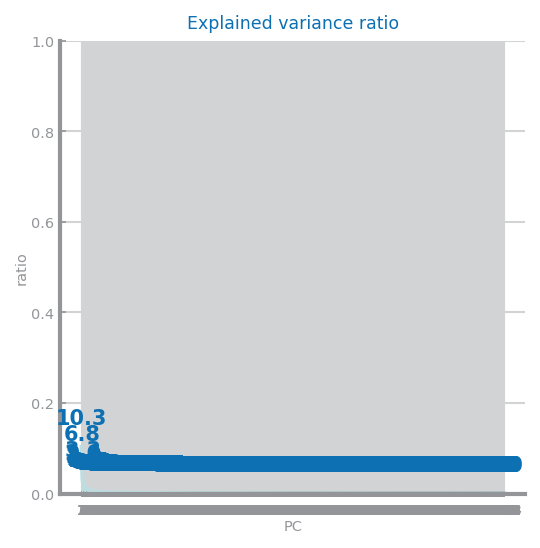

           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     3.982326  0.473448  0.460662 -3.392441  1.333565 -1.059230  1.480481   
1     0.356240  1.367329  1.632763 -0.724912 -1.150964 -0.805851  2.072165   
2     6.969627  2.882103 -0.127075  0.897167  0.232682  2.160409 -1.335815   
3     0.172945  2.226795  0.614964 -0.362905 -1.447209 -0.235496  1.532794   
4     1.376230  0.983562  0.985796 -2.181038  0.226371 -0.704255  1.600808   
...        ...       ...       ...       ...       ...       ...       ...   
6288 -0.675707  5.005083 -1.621082 -0.592963 -0.561090  0.390247  0.613237   
6289  3.426579  1.773402 -1.403743 -1.829182 -0.594794 -0.560742  2.719249   
6290  3.477635  0.519513 -0.873486 -2.320945  1.208611 -0.540574  1.844006   
6291  6.487489  4.566435 -0.763013  0.196586 -0.667218 -1.045935  2.847864   
6292  6.731222  3.733497  2.275940 -0.187251 -1.771048 -1.522338  0.994882   

           PC8       PC9      PC10  ...     PC141     PC142    

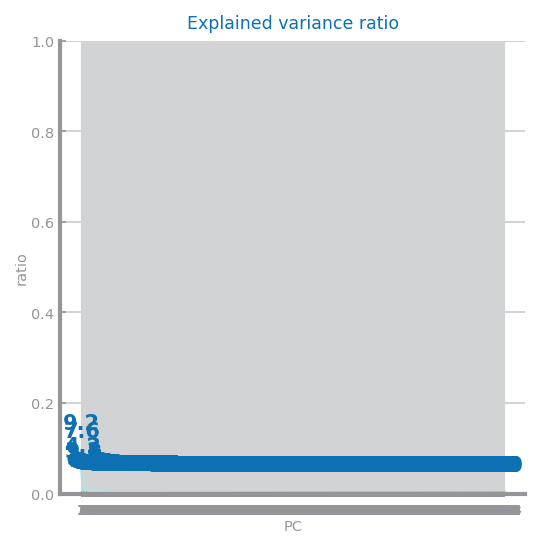

           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     3.478552  1.573211 -1.126312  3.108326  1.686884 -2.866909  1.342413   
1     3.260232 -1.925738  5.375467  2.742322  1.632196  0.171078  1.054622   
2     0.192447  6.627317  0.977517  0.997353  2.173891 -1.578585  1.080428   
3     4.027902  0.152454  0.117570  1.357017  0.188264 -2.568332 -0.016279   
4    -0.048253  5.378445  1.940091  2.325809 -1.065228  0.431748 -0.018171   
...        ...       ...       ...       ...       ...       ...       ...   
3843  2.996021  1.840936  0.274123  0.147610  1.711013 -2.416153  0.198414   
3844  4.343713  3.239140  0.827743  3.195537  0.554697  0.638651  0.299199   
3845  4.417976  0.926500 -0.671339  0.744140  0.376546 -1.814233  0.581274   
3846  6.487380  4.927890 -0.445111  1.198500 -0.396703 -0.086229  1.214213   
3847  7.440585  2.960746 -0.328149  1.021879  0.624077  3.364640  0.811376   

           PC8       PC9      PC10  ...     PC141     PC142    

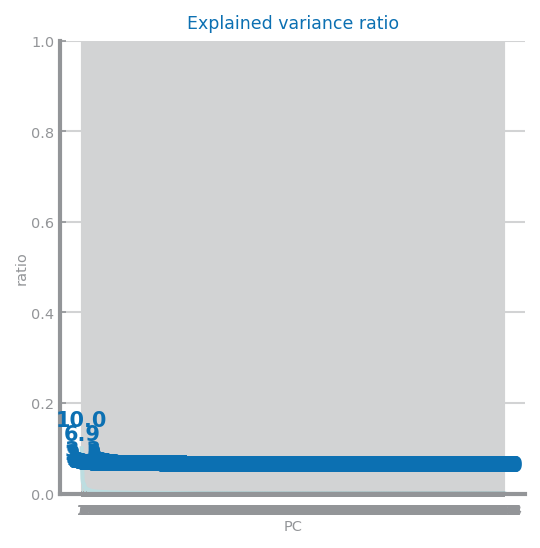

           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     3.247812  2.550344  0.394638 -3.694425 -0.138783 -0.269140  1.144943   
1    -0.641408  4.221397 -1.014847 -0.914580 -1.693310  0.726484  0.047475   
2     4.558083  3.290323  3.075752 -2.249386  0.432645  0.177934 -0.768031   
3     4.306793  1.608703 -0.931625 -1.246663  0.600675 -0.716954  0.032866   
4     6.633621  3.941709  2.458814 -0.159335  0.529438  0.820292 -0.271012   
...        ...       ...       ...       ...       ...       ...       ...   
2693 -0.656148  6.314668  2.709686 -2.195887 -1.376579 -0.844105  0.012440   
2694  3.509704  1.763201 -1.165639 -2.801929  0.649230  2.194792 -0.422570   
2695 -0.081478  1.929188  1.328973 -1.577710 -1.664431  1.236061 -0.638970   
2696  4.493617  1.286096 -1.054308 -2.083578 -0.584342 -1.128927  0.136359   
2697  0.337049  0.951330  1.634971  0.239808  0.202659 -0.275248 -0.409670   

           PC8       PC9      PC10  ...     PC141     PC142    

In [24]:
old_datasets = (trainData, balanced, testData)
new_datasets = ()

for dataset in old_datasets:
    target_data = dataset.pop('exp').reset_index().drop(columns='index')
    data = dataset

    from sklearn.decomposition import PCA

    mean = (data.mean(axis=0)).tolist()
    centered_data = data - mean
    cov_mtx = centered_data.cov()
    eigvals, eigvecs = np.linalg.eig(cov_mtx)

    pca = PCA()
    pca.fit(centered_data)
    PC = pca.components_
    var = pca.explained_variance_

    # PLOT EXPLAINED VARIANCE RATIO
    fig = plt.figure(figsize=(4, 4))
    plt.title('Explained variance ratio')
    plt.xlabel('PC')
    plt.ylabel('ratio')
    x_values = [str(i) for i in range(1, len(pca.components_) + 1)]
    bwidth = 0.5
    ax = plt.gca()
    ax.set_xticklabels(x_values)
    ax.set_ylim(0.0, 1.0)
    ax.bar(x_values, pca.explained_variance_ratio_, width=bwidth)
    ax.plot(pca.explained_variance_ratio_)
    for i, v in enumerate(pca.explained_variance_ratio_):
        ax.text(i, v+0.05, f'{v*100:.1f}', ha='center', fontweight='bold')
    plt.show()

    transf = pca.transform(data)
    data = pd.DataFrame(transf[:,:150], columns=[('PC%d' % (col + 1)) for col in range(150)])
    print(data)
    data = data.join(target_data, how='right')
    
    new_datasets += (data,)

In [26]:
new_datasets[0].to_csv('data/prepared_fe_146/data.csv', sep=';', index=False)
new_datasets[1].to_csv('data/prepared_b_fe_146/data.csv', sep=';', index=False)
new_datasets[2].to_csv('data/prepared_test_fe_146/data.csv', sep=';', index=False)

In [8]:
print(pca.explained_variance_)

[6.69759116e+00 4.60314926e+00 2.22187580e+00 ... 1.33429137e-03
 1.26134054e-03 1.08065461e-03]


In [14]:
total = 0
for v in range(len(pca.explained_variance_)):
    total += pca.explained_variance_[v]
    if total > 50:
        print(v)
        break

146
